In [ ]:
# Standard library
import os
import sys
import pprint

# Scientific and image processing (third-party)
import numpy as np
import scipy.io
import scipy.misc
from PIL import Image

# Visualization (third-party)
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# Deep learning
import tensorflow as tf

# Jupyter-specific (magic command, not valid in scripts)
%matplotlib inline

/tmp/ipython-input-1-2891300907.py:9: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  import scipy.misc


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

DEVICES AVAILABLE: 1


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
tf.random.set_seed(272)
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
with tf.device('/device:GPU:0'):
  vgg = tf.keras.applications.VGG19(include_top=False,
                                    input_shape=(img_size, img_size, 3),
                                    weights="/content/drive/MyDrive/Neural_Style_Transfer/pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5")

  vgg.trainable = False
pp.pprint(vgg)

<Functional name=vgg19, built=True>


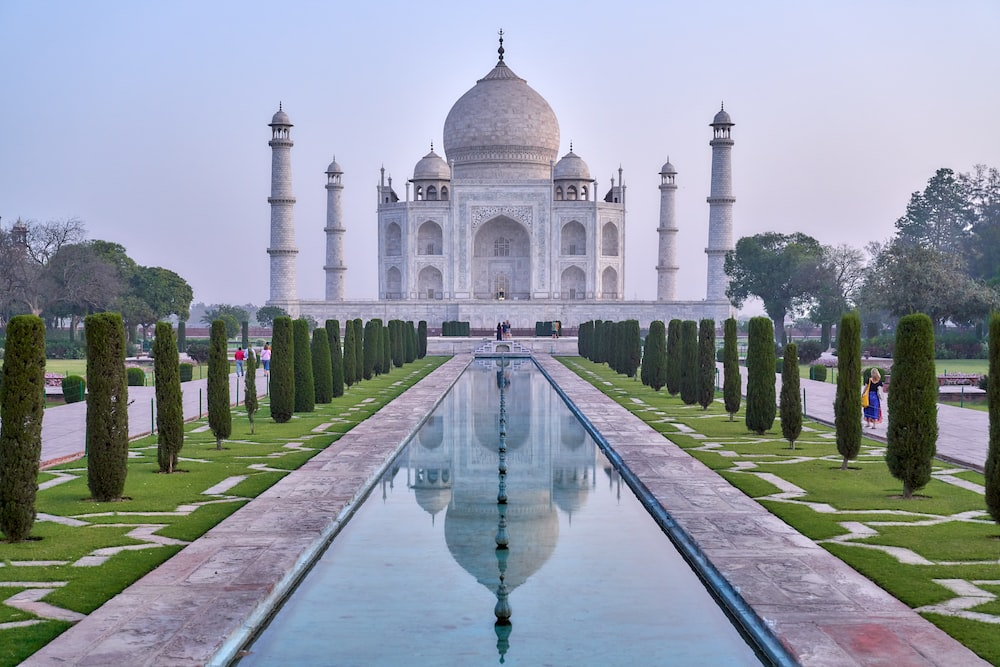

In [ ]:
content_image = Image.open("/content/drive/MyDrive/Neural_Style_Transfer/Content_Images/Taj Mahal.jpeg")
content_image

In [ ]:
def compute_content_cost(content_output, generated_output):

    a_C = content_output[-1]
    a_G = generated_output[-1]

    _, n_H, n_W, n_C = a_C.get_shape().as_list()

    a_C_unrolled = tf.reshape(a_C,shape=[_,n_H*n_W,n_C])
    a_G_unrolled = tf.reshape(a_G,shape=[_,n_H*n_W,n_C])

    J_content = (1/(n_H*n_W*n_C*4))*(tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled))))

    return J_content

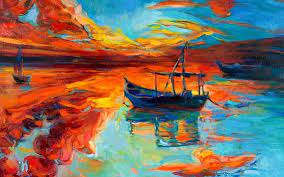

In [ ]:
example = Image.open("/content/drive/MyDrive/Neural_Style_Transfer/Style_Images/Unknown.jpeg")
example

In [ ]:
def gram_matrix(A):

    GA = tf.matmul(A,tf.transpose(A))

    return GA

In [ ]:
def compute_layer_style_cost(a_S, a_G):

    _, n_H, n_W, n_C = a_S.get_shape().as_list()


    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = tf.reduce_sum(tf.square(GS - GG))/(4.0 *(( n_H * n_W * n_C)**2))


    return J_style_layer

In [ ]:
for layer in vgg.layers:
    print(layer.name)

input_layer
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
vgg.get_layer('block5_conv4').output

<KerasTensor shape=(None, 25, 25, 512), dtype=float32, sparse=False, name=keras_tensor_20>

In [ ]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [ ]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):

    J_style = 0

    a_S = style_image_output[:-1]

    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):

        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        J_style += weight[1] * J_style_layer

    return J_style

In [ ]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):

    J = alpha * J_content + beta * J_style

    return J

(1, 400, 400, 3)


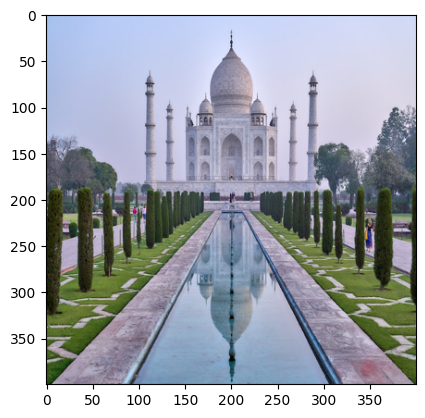

In [ ]:
content_image = np.array(Image.open("/content/drive/MyDrive/Neural_Style_Transfer/Content_Images/Taj Mahal.jpeg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

(1, 400, 400, 3)


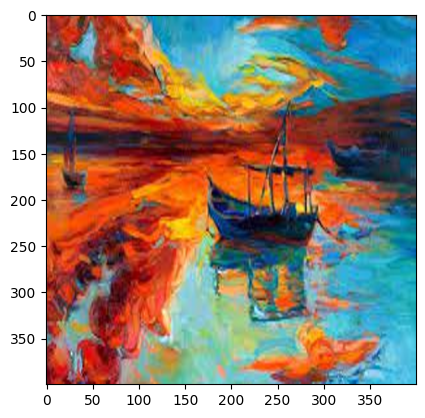

In [ ]:
style_image =  np.array(Image.open("/content/drive/MyDrive/Neural_Style_Transfer/Style_Images/Unknown.jpeg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

(1, 400, 400, 3)


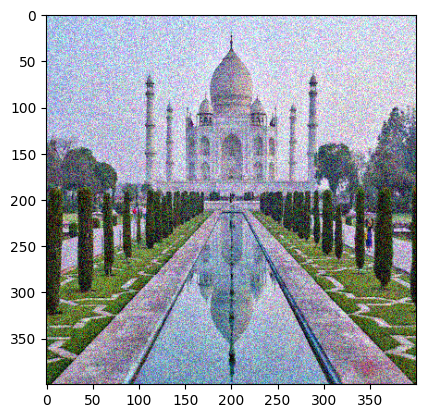

In [ ]:
## Added noise to the content image, to make integration smooth =>
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

In [ ]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [ ]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [ ]:
content_target = vgg_model_outputs(content_image)
style_targets = vgg_model_outputs(style_image)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 400, 400, 3))
  warnings.warn(msg)


In [ ]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

In [ ]:
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [ ]:
def clip_0_1(image):

    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):

    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [ ]:
generated_image = tf.Variable(generated_image)

In [ ]:
with tf.device('/device:GPU:0'):
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  @tf.function()
  def train_step(generated_image):
      with tf.GradientTape() as tape:

          a_G = vgg_model_outputs(generated_image)

          J_style = compute_style_cost(a_S, a_G)

          J_content = compute_content_cost(a_C, a_G)

          J = total_cost(J_content, J_style,alpha = 10, beta = 40)



      grad = tape.gradient(J, generated_image)

      optimizer.apply_gradients([(grad, generated_image)])
      generated_image.assign(clip_0_1(generated_image))

      return J

In [ ]:
epochs = 4001
for i in range(epochs):
    cost = train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} cost: {cost}")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        plt.show()

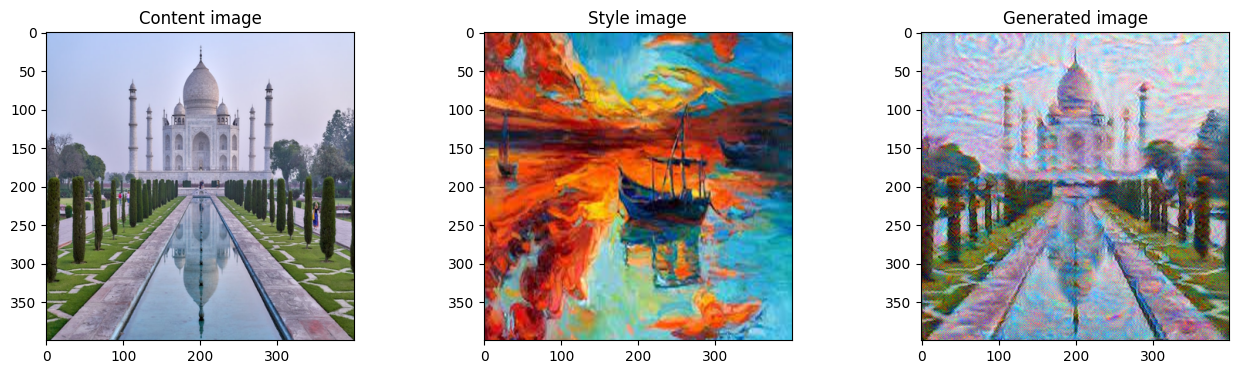

In [ ]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()